**TODO**
- remove cells that do not intersect area
- get centroid for hull

In [1]:
import os
from pathlib import Path
import calendar

import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, Polygon

import requests as rq

# for aWhere API
from header import AWhereAPI
from secret_codes import *

api_key = API_KEY
api_secret = API_SECRET

In [2]:
# Create aWhere object
aw = AWhereAPI(api_key, api_secret)

# To get auth token, encode secret and key
sc = aw.encode_secret_and_key(API_KEY, API_SECRET)

# Then call auth token
token = aw.get_oauth_token(sc)

In [3]:
""" Set variables for aWhere API call"""

# General endpoint
endpt = "https://api.awhere.com"

# Set up headers: auth and specific header for agronomics data
auth_headers = {"Authorization": "Bearer %s" % token,
                "Content-Type": 'application/json'}

agro_header = {"Authorization":  "Bearer %s" % token}

In [4]:
# Create path to home
home = str(Path.home())

# Create path to geojson since csv crashes Jupyter
path_to_marin = os.path.join(
    home, "Desktop", "drought-tracker", "data", "TIGER", "marin.geojson")

# Create df with 1 test county (Marin)
marin = gpd.read_file(path_to_marin)

marin = marin.to_crs("EPSG:4326")

C:\Users\dphil\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [5]:
# Create path to surrounding counties as context
path_to_counties = os.path.join(home, "Desktop", "drought-tracker", "data", "TIGER", "cb_2018_us_county_500k.shp")

counties = gpd.read_file(path_to_counties)

ca_counties = counties[counties.NAME.str.contains('San Francisco') | counties.NAME.str.contains('Sonoma')]

In [6]:
def create_awhere_grid(aoi, out_crs, calc_crs):
    """
    Parameters
    ----------
    aoi: Geopandas GeoDataFrame
        One-element GeoDataFrame containing area over which
        to draw grid
    
    out_crs: numeric string
        String of EPSG code for exported GDF
    
    calc_crs: numeric string
        String of EPSG code for CRS used
        to calculate grid. CRS must have units of meters
        
    Returns
    -------
    GeoDataFrame containing 9km x 9km cells
    """   
    
    # Reproject aoi to CRS using meters for aWhere grid cells
    aoi = aoi.to_crs(f'epsg:{calc_crs}')
    
    # Get x and y min and max from total boundaries
    xmin, ymin, xmax, ymax = aoi.total_bounds
    
    # Set side of grid cell to 9 km
    side = 9000
    
    # Create x values for x points for rows
    x_range = np.arange(int(np.floor(xmin)), int(np.ceil(xmax)), side)
    
    # Create y values
    y_range = np.arange(int(np.floor(ymin)), int(np.floor(ymax)), side)
    
    # Create empty list to hold grid cells
    polygons = []
    
    for x in x_range:
        for y in y_range:
            polygons.append(Polygon([(x,y), (x+side, y), (x+side, y+side), (x,y+side)]))
            
    grid = gpd.GeoDataFrame({'geometry': polygons})
    
    grid.crs = f'EPSG:{calc_crs}'
    
    # Convert to out_crs
    grid = grid.to_crs(f"EPSG:{out_crs}")
    
    return grid

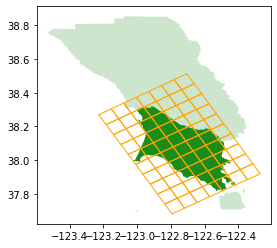

In [7]:
# Create grid polygon
grid = create_awhere_grid(aoi=marin,
                          out_crs='4326',
                          calc_crs='2019')

# Add centroid column
grid['centroid'] = grid.geometry.apply(lambda poly: poly.centroid)


# Check to see if everything looks correct
fig, ax = plt.subplots()
grid.plot(color="none", linewidth=1, edgecolor='orange', ax=ax, zorder=3)
marin.plot(color='green', alpha=0.9, ax=ax)
ca_counties.plot(color="green", alpha=0.2, ax=ax)

plt.show()

In [8]:
def get_ppet(grid_df, start_date, end_date, drop_null=False, testing=False):
    """
    Paraemeters
    -----------
    grid_df: Geopandas GeoDataFrame
        Contains gridded area to fetch argonomics values for

    start_date: string
        Format "YYYY-MM-DD"

    end_date: string
        Format "YYYY-MM-DD"

    drop_null: boolean (optional)
        Drop grid cells that have null values returned from
        API request for agronomics data. Often null values 
        result from grid cell lying in a body of water.

    testing: boolean (optional)
        Returns sample P/PET values for each grid cell 
        from 0 - 30 mm. Used for testing; bypasses API call.

    Returns
    -------
    grid_df: Geopandas GeoDataFrame
        Contains gridded input area with requested values.

    """

    # For testing, generate random values for each cell
    if testing == True:
        grid_df['test_ppet'] = [np.random.randint(
            0, 30) for i in range(0, grid.shape[0])]

        return grid_df

    # Add P/PET column if it does not exist and initialize to 0
    if 'ppet' not in grid_df.columns:
        grid_df = grid_df.assign(ppet=0)

    # Iterate thru rows (cells) in gdf
    for index, row in grid_df.iterrows():

        # Get centroid coordinates from each cell to pass to API
        lat = round(row.centroid.y, 5)
        lon = round(row.centroid.x, 5)

        """Build unique URL"""
        # URL to historical agronomics (norms)
        hist_ag_url = f"/v2/agronomics/locations/{lat},{lon}/agronomicvalues/{start_date},{end_date}"

        # Endpoint suffix to get all accumulations
        url_append = "?properties=accumulations"

        # Full URL, endpt is defined up top
        full_url = endpt + hist_ag_url + url_append

        # Get JSON
        ag_norms_json = rq.get(full_url, headers=agro_header).json()

        # Try to pull data from return JSON
        try:
            grid_df.loc[index, 'ppet'] = ag_norms_json.get(
                'accumulations').get('ppet')

        except:
            grid_df.loc[index, 'ppet'] = np.nan

        # Drop null cells if requested
        if drop_null == True:
            grid_df = grid_df[grid_df.ppet.isnull() == False]

    return grid_df


ppet_grid = get_ppet(grid_df=grid,
                     start_date="2020-04-01",
                     end_date="2020-04-30",
                     drop_null=True,
                     testing=False)

C:\Users\dphil\Miniconda3\envs\earth-analytics-python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
def binary_threshold(gdf, daily_acc_ppet_threshold, month, year):
    
    # Find monthly accumulated P/PET
    days_in_month = calendar.monthrange(year, month)[1]
    
    # Calculate monthly accumulated P/PET based on user's threshold
    monthly_acc_ppet = days_in_month * daily_acc_ppet_threshold
    
    # Add Boolean flag column if meets threshold
    gdf['meet_thresh'] = gdf['ppet'].apply(lambda x: 1 if x >= monthly_acc_ppet else 0)
    
    return gdf

test = binary_threshold(gdf=ppet_grid, 
                        daily_acc_ppet_threshold = 0.2, 
                        month=4, 
                        year=2020)

In [10]:
def to_convex_hull(gdf, crs):
    
    # Drop all rows that do not meet threshold
    meet_thresh_only = gdf[gdf.meet_thresh == 1]
    
    # Dissolve polygons that meet threshold
    meet_thresh_dissolve = meet_thresh_only.dissolve(by='meet_thresh')
    
    # Explode polygons so that there are unique contiguous areas
    exploded = meet_thresh_dissolve.explode()

    # Drop multi-index outer level generated from dissolve
    exploded = exploded.droplevel(0)
    
    # Add area column
    exploded["sqkm"] = exploded['geometry'].area/ 10**6
    
    # Get largest polygon
    largest = exploded[exploded.sqkm == exploded.sqkm.max()]
    
    # Generate convex hull
    hull_largest = largest.convex_hull

    # Convert to gdf
    hull = gpd.GeoDataFrame(hull_largest, crs=f'epsg:{crs}')

    # Rename column '0' to 'geometry'
    hull.rename(columns={0:"geometry"}, inplace=True)
    
    return hull

In [11]:
hull = to_convex_hull(test, 4326)

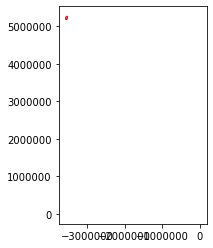

In [59]:
fig, ax = plt.subplots()

hull.plot(ax=ax, color='none', edgecolor='red', zorder=4)
test.plot(column='ppet', ax=ax, alpha=0.6, zorder=3)
marin.plot(color='green', alpha=0.9, ax=ax)
#ca_counties.plot(color="green", alpha=0.2, ax=ax)

plt.show()

In [57]:
def drought_stats_binary(grid_gdf, hull_gdf, crs):
    
    # Make projections same
    grid_gdf = grid_gdf.to_crs(f"EPSG:{crs}")
    
    hull_gdf = hull_gdf.to_crs(f"EPSG:{crs}")
    
    # Convert hull_gdf to shapely polygon
    hull_shape = Polygon(hull.geometry[0])
    
    # Set summary variables to 0
    inter_area_run_sum = 0
    
    # This is a list to more easily calculate average (using sum then len)
    inter_ppet_run_sum = []
    
    # Loop through grid cells in grid_gdf
    for index, row in test.iterrows():
    
        # Convert to shapely Polygon
        grid_cell = Polygon(row.geometry)
        
        # If cell intersects the hull:
        if grid_cell.intersects(hull_shape):

            # Find the area of the intersection polygon
            intersect_area = grid_cell.intersection(hull_shape).area
            
            # Find the proportional split of grid cell's P/PET
            proportional_ppet = (intersect_area / row.geometry.area) * row.ppet
            
            # Append it to the list
            inter_ppet_run_sum.append(proportional_ppet)
    
    # Find average P/PET per cell
    inter_ppet = round((sum(inter_ppet_run_sum) / len(inter_ppet_run_sum)), 3)
    
    print(f"Total droughted area: {round(hull_shape.area, 3)}")

    print(f"Average P/PET per cell in droughted area: {inter_ppet}")
    
drought_stats_binary(test, hull, "2163")

Total droughted area: 3118500000.0
Average P/PET per cell in droughted area: 5.092
